In [1]:
import os
import tqdm
import nibabel
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt

import lib
plt.style.use('ggplot')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
ROI = lib.roi.VolumeWMParc()
indices = ROI.get_idx(ROI.get_roi_id('CEREBELLUM-CORTEX'))
exid = ROI.get_idx(ROI.get_roi_id('CEREBELLUM-CORTEX'), exclude_specified_id=True)

# Spatial smoothing

In [4]:
sub_list = lib.basic.SUB_AVAILABLE
progress_bar = tqdm.tqdm(total=len(sub_list))
for sub_id in sub_list:
    progress_bar.update(1)
    if os.path.isfile(f'temp/{sub_id}_myelin_map.nii.gz'):
        continue
    
    myelin_map = lib.myelin.get_vol_map(sub_id)
    nib_img = lib.niio.get_vol_obj(myelin_map)
    nibabel.save(nib_img, f'temp/{sub_id}_myelin_map.nii.gz')

    cmd = f'fslmaths temp/{sub_id}_myelin_map.nii.gz -s {4 / 2.355:.2f} temp/Smoothed_{sub_id}_myelin_map.nii.gz'
    !$cmd

100%|██████████| 652/652 [31:35<00:00,  3.07s/it]

# Generate mean myelination map

In [5]:
mean_smoothed = np.row_stack([nibabel.load(f'temp/Smoothed_{sub_id}_myelin_map.nii.gz').get_fdata()[indices] for sub_id in sub_list]).mean(axis=0)

nib_img = lib.niio.get_vol_obj(ROI.invert(mean_smoothed, ROI.get_roi_id('CEREBELLUM-CORTEX')))
nibabel.save(nib_img, f'temp/mean_smoothed_myelin_map.nii.gz')

# Inspect mean myelination map

In [3]:
nib_img = nibabel.load(f'temp/mean_smoothed_myelin_map.nii.gz')
data = nib_img.get_fdata()[indices]

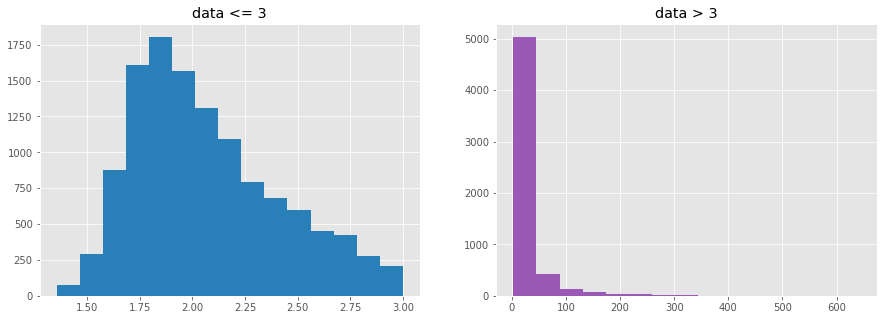

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(data[data <= 3], bins=15, color='#2980b9')
axes[0].set_title('data <= 3')
axes[1].hist(data[data > 3], bins=15, color='#9b59b6')
axes[1].set_title('data > 3')
plt.savefig('temp/hist_separated_by_3.svg')
plt.show()

In [6]:
print(np.where(data >= 3)[0].shape[0], data.shape[0])

5778 17853


In [7]:
# Export to a mask file
data = nib_img.get_fdata()
data[data <= 3] = 1
data[data >= 3] = 0
nib_img = lib.niio.get_vol_obj(data)
nibabel.save(nib_img, 'data/myelin_grad/cb_mask.nii.gz')